<a href="https://colab.research.google.com/github/fischsauce/Fashion-GAN/blob/master/Week_6_Fashion_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Fashion GAN using Tensorflow & Keras



### *References:*

> https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3


> https://github.com/roatienza/Deep-Learning-Experiments/blob/master/Experiments/Tensorflow/GAN/dcgan_mnist.py

> https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

> https://github.com/R-Suresh/GAN_fashion_MNIST/blob/master/gan.py





## Imports from the referenced github repo:

In [0]:
import tensorflow as tf
import pandas

import matplotlib.pyplot as plt

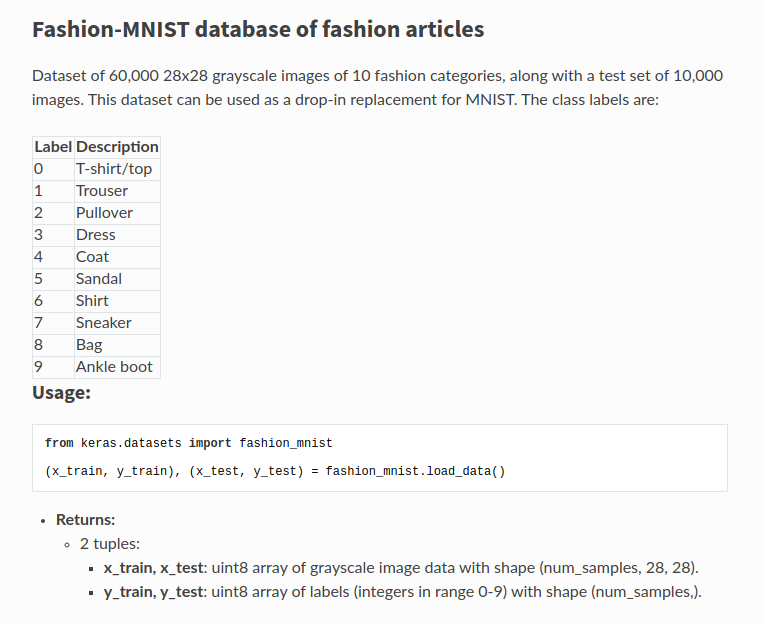

In [0]:
from IPython.display import Image
Image('/content/dataset_info.png')

### *Let's make a dictionary for these labels:*

In [0]:
labels = {0:'t-shirt',1:'trouser',2:'pull_over!',3:'dressy dress',4:'coat',5:'sandals',6:'shirt',7:'sneakier',8:'bag',9:'booty'}

In [0]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

### *Getting a feel for the data:*

In [0]:
x_train.shape

(60000, 28, 28)

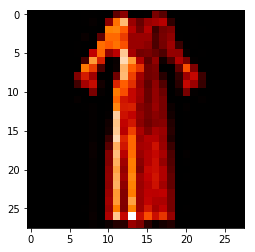

In [0]:
plt.imshow(x_train[5675], cmap='gist_heat')

### *Looks like a dress to me, but let's lookup the label in our dictionary so and slowly build confidence in this realm of strange new datas:*

In [0]:
print(labels[y_train[5675]])

dressy dress


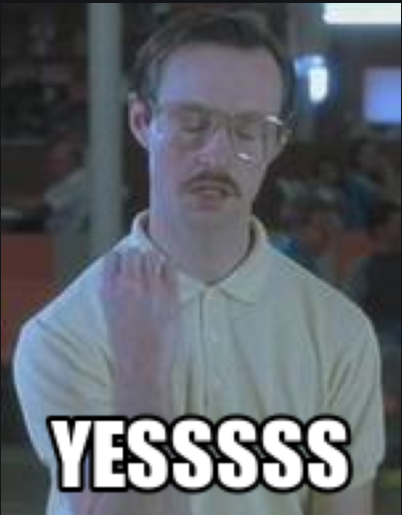

In [0]:
Image('/content/yesss.png')

In [0]:
x_test.shape

(10000, 28, 28)

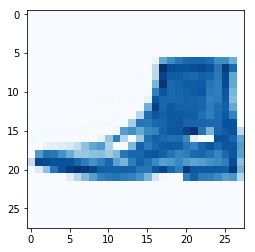

In [0]:
plt.imshow(x_test[5975], cmap='Blues')

In [0]:
print(labels[y_test[5975]])

booty


### *Ok, everything seems to be in order, enough procrastination, let's get on with the main event!*


> ## "This is a binary classification problem:
* ###  Inputs: Image with one channel and 28×28 pixels in size.
* ### Outputs: Binary classification, likelihood the sample is real (or fake)."


https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/



### *OK ok ok, that was probably a waste of time checking out the labels, since:*



> ## "The labels aren’t needed because the only labels we will be using are 0 for fake and 1 for real. These are real images, so they will all be assigned a label of 1 at the discriminator."


https://hub.packtpub.com/generative-adversarial-networks-using-keras/

In [0]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

> ## "Now that we’ve assembled both the generator and the discriminator, we need to assemble a third model that is the stack of both models together that we can use for training the generator given the discriminator loss."

In [0]:
discriminator = build_discriminator(img_shape=(28, 28, 1))
generator = build_generator()
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False ##! Important
real = discriminator(img)
combined = Model(z, real)








-- Discriminator -- 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (N

In [0]:
gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
disc_optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy',
optimizer=disc_optimizer,
metrics=['accuracy'])

generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [0]:
noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((half_batch, 1))

IndentationError: ignored